In [ ]:
# Are we using a GPU?
!nvidia-smi

Tue Jul 19 14:10:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-19 14:10:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   155MB/s    in 1.0s    

2022-07-19 14:10:40 (155 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
# Create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-07-19 14:10:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-19 14:10:45 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Model 1: Creating Base Model with 10% data without Transfer Learning & Data Augmentation of 10 food classes

In [ ]:
# Create our own model
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])


In [ ]:
# Compile
model_1.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                experiment_name="10_food_classes_10_percent_without_TL_DA")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/10_food_classes_10_percent_without_TL_DA/20220719-141049
Epoch 1/5
24/24 [==============================] - 27s 637ms/step - loss: 2.3474 - accuracy: 0.0893 - val_loss: 2.3027 - val_accuracy: 0.0992
Epoch 2/5
24/24 [==============================] - 14s 610ms/step - loss: 2.2948 - accuracy: 0.1080 - val_loss: 2.2754 - val_accuracy: 0.1208
Epoch 3/5
24/24 [==============================] - 14s 613ms/step - loss: 2.2279 - accuracy: 0.1533 - val_loss: 2.2245 - val_accuracy: 0.1444
Epoch 4/5
24/24 [==============================] - 15s 662ms/step - loss: 2.0778 - accuracy: 0.2360 - val_loss: 2.2651 - val_accuracy: 0.1680
Epoch 5/5
24/24 [==============================] - 14s 618ms/step - loss: 1.9178 - accuracy: 0.3360 - val_loss: 2.2081 - val_accuracy: 0.1924


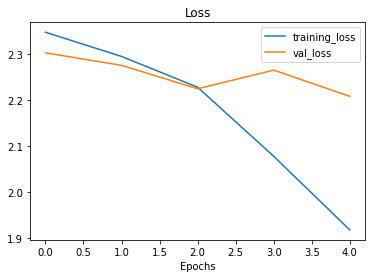

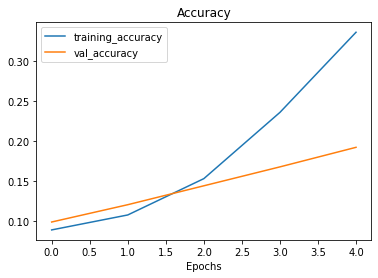

In [ ]:
plot_loss_curves(history_1)

### Model 2: Creating model with 1% data using Transfer Learning and Data Augmentation of 10 food classes

In [ ]:
# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-07-19 14:12:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   304MB/s    in 0.4s    

2022-07-19 14:12:22 (304 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

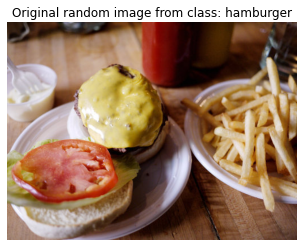

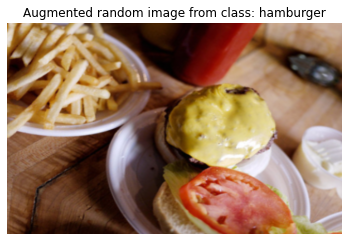

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup input shape and base model, freezing the base model layers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("tensorflow_hub", "10_food_classes_1_percent_with_TL_DA")])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: tensorflow_hub/10_food_classes_1_percent_with_TL_DA/20220719-141227
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3769 - accuracy: 0.1143 - val_loss: 2.2453 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0809 - accuracy: 0.2714 - val_loss: 2.1412 - val_accuracy: 0.2089
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9475 - accuracy: 0.3571 - val_loss: 2.0491 - val_accuracy: 0.2895
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8246 - accuracy: 0.4429 - val_loss: 1.9498 - val_accuracy: 0.3701
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6942 - accuracy: 0.5000 - val_loss: 1.8482 - val_accuracy: 0.4359


In [ ]:
results_1_percent_data_aug = model_2.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 76ms/step - loss: 1.8536 - accuracy: 0.4316


[1.8536367416381836, 0.43160000443458557]

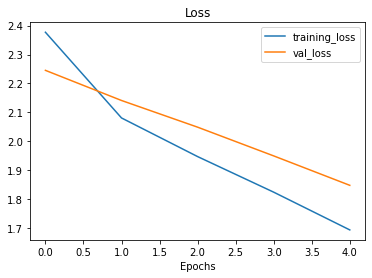

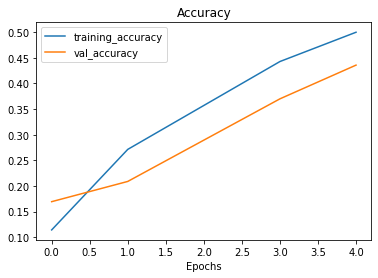

In [ ]:
plot_loss_curves(history_2)

### Model 3: Creating model with 10% data using Transfer Learning and Data Augmentation of 10 food classes

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
# Create model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) #
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile EfficientNet model
model_3.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

# Fit EfficientNet model
history_3 = model_3.fit(train_data_10_percent, # only use 10% of training data
                        epochs=5, # train for 5 epochs
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                # Track logs under different experiment name
                                                                experiment_name="10_food_classes_10_percent_with_TL_DA"),
                                    checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/10_food_classes_10_percent_with_TL_DA/20220719-141308
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.3389 - accuracy: 0.0840
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 963ms/step - loss: 2.3389 - accuracy: 0.0840 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.3213 - accuracy: 0.1053
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 815ms/step - loss: 2.3213 - accuracy: 0.1053 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 2.3298 - accuracy: 0.1000
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 848ms/step - loss: 2.3298 - accuracy: 0.1000 - val_loss: 2.3041 - val_acc

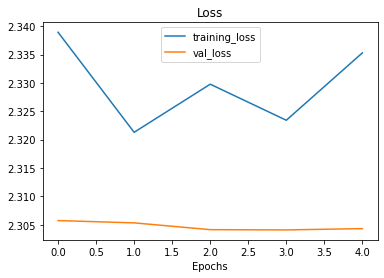

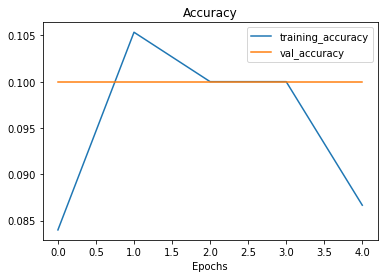

In [ ]:
plot_loss_curves(history_3)

### Model 4: Creating model with 100% data using Transfer Learning and Data Augmentation of 10 food classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-07-19 14:14:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   244MB/s    in 2.0s    

2022-07-19 14:14:58 (244 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_4 = Model(inputs, outputs)

# Compile the model
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(train_data_10_classes_full,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_classes_full),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("tensorflow_hub", "10_food_classes_100_percent_with_TL_DA")])

Saving TensorBoard log files to: tensorflow_hub/10_food_classes_100_percent_with_TL_DA/20220719-141507
Epoch 1/5
235/235 [==============================] - 67s 260ms/step - loss: 1.0731 - accuracy: 0.6823 - val_loss: 0.5204 - val_accuracy: 0.8480
Epoch 2/5
235/235 [==============================] - 54s 229ms/step - loss: 0.6912 - accuracy: 0.7908 - val_loss: 0.4449 - val_accuracy: 0.8656
Epoch 3/5
235/235 [==============================] - 48s 202ms/step - loss: 0.6066 - accuracy: 0.8092 - val_loss: 0.4033 - val_accuracy: 0.8712
Epoch 4/5
235/235 [==============================] - 46s 193ms/step - loss: 0.5683 - accuracy: 0.8209 - val_loss: 0.3837 - val_accuracy: 0.8700
Epoch 5/5
235/235 [==============================] - 43s 183ms/step - loss: 0.5444 - accuracy: 0.8288 - val_loss: 0.3718 - val_accuracy: 0.8812


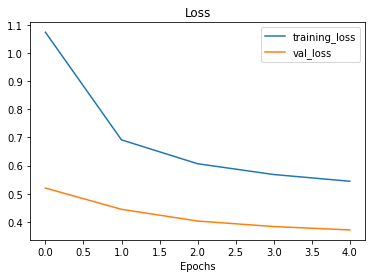

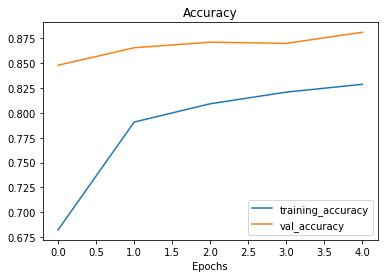

In [ ]:
plot_loss_curves(history_4)

### Model 5: Creating model with 10% data using Transfer Learning and Data Augmentation of 101 food classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-07-19 14:20:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  66.8MB/s    in 20s     

2022-07-19 14:21:10 (76.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_5 = tf.keras.Model(inputs, outputs)

In [ ]:
model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_5 = model_5.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("tensorflow_hub", "101_food_classes_10_percent_with_TL_DA"),
                                                      checkpoint_callback])

Saving TensorBoard log files to: tensorflow_hub/101_food_classes_10_percent_with_TL_DA/20220719-142129
Epoch 1/5
237/237 [==============================] - 52s 193ms/step - loss: 3.4876 - accuracy: 0.2471 - val_loss: 2.6366 - val_accuracy: 0.4168
Epoch 2/5
237/237 [==============================] - 44s 185ms/step - loss: 2.3592 - accuracy: 0.4564 - val_loss: 2.2244 - val_accuracy: 0.4725
Epoch 3/5
237/237 [==============================] - 40s 169ms/step - loss: 1.9627 - accuracy: 0.5352 - val_loss: 2.0540 - val_accuracy: 0.4939
Epoch 4/5
237/237 [==============================] - 42s 174ms/step - loss: 1.7542 - accuracy: 0.5783 - val_loss: 1.9524 - val_accuracy: 0.5037
Epoch 5/5
237/237 [==============================] - 38s 157ms/step - loss: 1.5944 - accuracy: 0.6062 - val_loss: 1.9559 - val_accuracy: 0.4921


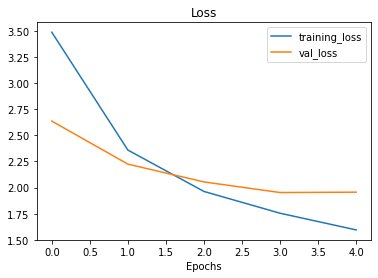

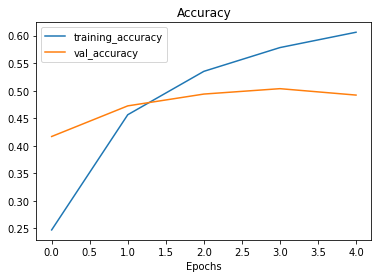

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_5.evaluate(test_data)

790/790 [==============================] - 57s 73ms/step - loss: 1.7363 - accuracy: 0.5461


[1.73634934425354, 0.5460990071296692]

# FINAL MODEL

Model 6: Creating model with 100% data using Transfer Learning and Data Augmentation of 101 food classes

In [ ]:
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteRYEFK6/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteRYEFK6/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess_img(image, label, img_shape = 224, scale = False):
  image = tf.image.resize(image, [img_shape, img_shape])
  if scale:
    image = image/255.
  return tf.cast(image, tf.float32), label

In [ ]:
#converting it to batches
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path,
                                                      monitor = "val_acc",
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0)

In [ ]:
class_names = ds_info.features["label"].names
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
#x = preprocessing.DataAugmentation()
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "GlobAvgPool2D")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_6 = tf.keras.Model(inputs, outputs)

In [ ]:
model_6.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
history_6 = model_6.fit(train_data,
          epochs=3,
          steps_per_epoch = len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[create_tensorboard_callback("tensorflow_hub", "101_food_classes_100_percent_with_TL_DA"),
                     model_checkpoint])

Saving TensorBoard log files to: tensorflow_hub/101_food_classes_100_percent_with_TL_DA/20220719-143654
Epoch 1/3
1608/2368 [===================>..........] - ETA: 53s - loss: 1.9691 - accuracy: 0.5316

In [ ]:
model_6.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 1.0932 - accuracy: 0.7057


[1.0931551456451416, 0.7056633830070496]

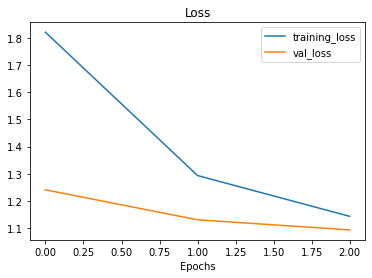

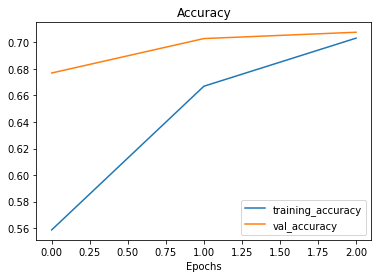

In [ ]:
plot_loss_curves(history_6)

In [ ]:
model_6.save("Final_Model.h5")

### Classifying an image

In [ ]:
#Importing an external image
path_to_img = "/content/101_food_classes_10_percent/test/cheesecake/1023543.jpg"
label = "Cheesecake"
img = mpimg.imread(path_to_img)

In [ ]:
#Preprocessing the image
img_2, _ = preprocess_img(img, label)
img_2 = tf.expand_dims(img_2, axis = 0)
img_2.shape

TensorShape([1, 224, 224, 3])

In [ ]:
#Obtaining the 101 food class names
test_data_2 = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)
class_names = test_data_2.class_names
class_names

Found 25250 files belonging to 101 classes.


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Actual Label:  Cheesecake
Predicted Label:  cheesecake


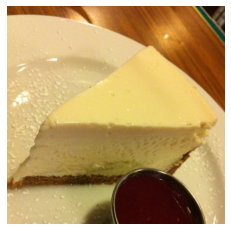

In [ ]:
#Classifying the image and printing the predicted class
import numpy as np
print('Actual Label: ', label)
print('Predicted Label: ', class_names[tf.argmax(model_6.predict(img_2),1)[0]])
plt.imshow(img)
plt.axis("off");